<a href="https://colab.research.google.com/github/lustraka/Data_Analysis_Workouts/blob/main/Communicate_Data_Findings/Part_I_exploration_ames.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Analysis of House Prices in Ames, Iowa - Part I
## by Lubomir Straka

## Introduction
> Introduce the dataset

>**Rubric Tip**: Your code should not generate any errors, and should use functions, loops where possible to reduce repetitive code. Prefer to use functions to reuse code statements.

> **Rubric Tip**: Document your approach and findings in markdown cells. Use comments and docstrings in code cells to document the code functionality.

>**Rubric Tip**: Markup cells should have headers and text that organize your thoughts, findings, and what you plan on investigating next.  



## Preliminary Wrangling


In [9]:
# Import all packages and set plots to be embedded inline
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

> Load in your dataset and describe its properties through the questions below. Try and motivate your exploration goals through this section.

This project processes a data set describing the sale of individual residential property in Ames, Iowa from 2006 to 2010. The [Ames Housing dataset](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) was downloaded from Kaggle.com and is hosted on this project's GitHub repository to avoid the need of working with the Kaggle's API.

In [4]:
# Load the Ames Housing dataset
path = 'https://raw.githubusercontent.com/lustraka/Data_Analysis_Workouts/main/Communicate_Data_Findings/ames_train_data.csv'
ames = pd.read_csv(path, index_col='Id')
print(ames.shape)

(1460, 80)


In [7]:
################
# Wrangle data #
################
# The numeric features are already encoded correctly (`float` for
# continuous, `int` for discrete), but the categoricals we'll need to
# do ourselves. Note in particular, that the `MSSubClass` feature is
# read as an `int` type, but is actually a (nominative) categorical.

# The categorical features nominative (unordered)
catn = ["MSSubClass", "MSZoning", "Street", "Alley", "LandContour", "LotConfig",
        "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", 
        "RoofStyle", "RoofMatl", "Exterior1st", "Exterior2nd", "MasVnrType", 
        "Foundation", "Heating", "CentralAir", "GarageType", "MiscFeature", 
        "SaleType", "SaleCondition"]


# The categorical features ordinal (ordered) 

# Pandas calls the categories "levels"
five_levels = ["Po", "Fa", "TA", "Gd", "Ex"]
ten_levels = list(range(10))

cato = {
    "OverallQual": ten_levels,
    "OverallCond": ten_levels,
    "ExterQual": five_levels,
    "ExterCond": five_levels,
    "BsmtQual": five_levels,
    "BsmtCond": five_levels,
    "HeatingQC": five_levels,
    "KitchenQual": five_levels,
    "FireplaceQu": five_levels,
    "GarageQual": five_levels,
    "GarageCond": five_levels,
    "PoolQC": five_levels,
    "LotShape": ["Reg", "IR1", "IR2", "IR3"],
    "LandSlope": ["Sev", "Mod", "Gtl"],
    "BsmtExposure": ["No", "Mn", "Av", "Gd"],
    "BsmtFinType1": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "BsmtFinType2": ["Unf", "LwQ", "Rec", "BLQ", "ALQ", "GLQ"],
    "Functional": ["Sal", "Sev", "Maj1", "Maj2", "Mod", "Min2", "Min1", "Typ"],
    "GarageFinish": ["Unf", "RFn", "Fin"],
    "PavedDrive": ["N", "P", "Y"],
    "Utilities": ["NoSeWa", "NoSewr", "AllPub"],
    "CentralAir": ["N", "Y"],
    "Electrical": ["Mix", "FuseP", "FuseF", "FuseA", "SBrkr"],
    "Fence": ["MnWw", "GdWo", "MnPrv", "GdPrv"],
}

# Add a None level for missing values
cato = {key: ["None"] + value for key, value in
                  cato.items()}


def encode_dtypes(df):
    """Encode nominal and ordinal categorical variables."""

    global catn, cato

    # Nominal categories
    for name in catn:
        df[name] = df[name].astype("category")
        # Add a None category for missing values
        if "None" not in df[name].cat.categories:
            df[name].cat.add_categories("None", inplace=True)
    # Ordinal categories
    for name, levels in cato.items():
        df[name] = df[name].astype(pd.CategoricalDtype(levels,
                                                    ordered=True))
    return df

def impute_missing(df):
    """Impute zeros to numerical and None to categorical variables."""

    for name in df.select_dtypes("number"):
        df[name] = df[name].fillna(0)
    for name in df.select_dtypes("category"):
        df[name] = df[name].fillna("None")
    return df

def clean_data(df):
    """Remedy typos and mistakes based on EDA."""

    global cato
    # YearRemodAdd: Remodel date (same as construction date if no remodeling or additions)
    df.YearRemodAdd = np.where(df.YearRemodAdd < df.YearBuilt, df.YearBuilt, df.YearRemodAdd)
    assert len(df.loc[df.YearRemodAdd < df.YearBuilt]) == 0, 'Check YearRemodAdd - should be greater or equal then YearBuilt'
    
    # Check range of years
    yr_max = 2022
    # Some values of GarageYrBlt are corrupt. Fix them by replacing them with the YearBuilt
    df.GarageYrBlt = np.where(df.GarageYrBlt > yr_max, df.YearBuilt, df.GarageYrBlt)
    assert df.YearBuilt.max() < yr_max and df.YearBuilt.min() > 1800, 'Check YearBuilt min() and max()'
    assert df.YearRemodAdd.max() < yr_max and df.YearRemodAdd.min() > 1900, 'Check YearRemodAdd min() and max()'
    assert df.YrSold.max() < yr_max and df.YrSold.min() > 2000, 'Check YrSold min() and max()'
    assert df.GarageYrBlt.max() < yr_max and df.GarageYrBlt.min() >= 0, 'Check GarageYrBlt min() and max()'
    
    # Check values of ordinal catagorical variables
    for k in cato.keys():
      assert set(df[k].unique()).difference(df[k].cat.categories) == set(), f'Check values of {k}'
    
    # Check typos in nominal categorical variables
    df['Exterior2nd'] = df['Exterior2nd'].replace({'Brk Cmn':'BrkComm', 'CmentBd':'CemntBd', 'Wd Shng':'WdShing'})
    # Renew a data type after replacement
    df['Exterior2nd'] = df['Exterior2nd'].astype("category")
    if "None" not in df['Exterior2nd'].cat.categories:
        df['Exterior2nd'].cat.add_categories("None", inplace=True)

    return df

def label_encode(df):
    """Encode categorical variables using their dtype setting."""

    X = df.copy()
    for colname in X.select_dtypes(["category"]):
        X[colname] = X[colname].cat.codes
    return X

# Pre-process data
ames = encode_dtypes(ames)
ames = impute_missing(ames)
ames = clean_data(ames)

ames.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   MSSubClass     1460 non-null   category
 1   MSZoning       1460 non-null   category
 2   LotFrontage    1460 non-null   float64 
 3   LotArea        1460 non-null   int64   
 4   Street         1460 non-null   category
 5   Alley          1460 non-null   category
 6   LotShape       1460 non-null   category
 7   LandContour    1460 non-null   category
 8   Utilities      1460 non-null   category
 9   LotConfig      1460 non-null   category
 10  LandSlope      1460 non-null   category
 11  Neighborhood   1460 non-null   category
 12  Condition1     1460 non-null   category
 13  Condition2     1460 non-null   category
 14  BldgType       1460 non-null   category
 15  HouseStyle     1460 non-null   category
 16  OverallQual    1460 non-null   category
 17  OverallCond    1460 non-null   ca

### What is the structure of the Ames Housing dataset?

The data set contains 1460 observations and a large number of explanatory variables (23 nominal, 23 ordinal, 14 discrete, and 20 continuous) involved in assessing home values. These 79 explanatory variables plus one response variable (SalePrice) describe almost every aspect of residential homes in Ames, Iowa. The Ames Housing dataset was originally compiled by Dean De Cock for use in data science education. 

### What is the main feature of interest in the Ames Housing dataset?

The response variable of our interest is *SalePrice*.

### What features in the dataset do we think will help support our investigation into the price of houses?

We can define three possible sub-sets of our explanatory variables: building, space, and location. By 'building' we mean a variable that relates to the physical characterization of the building (e.g. *OverallQual*). By 'space' we mean a variable that reports space properties of the house (e.g. *TotalBsmtSF*). Finally, by 'location', we mean a variable that gives information about the place where the house is located (e.g. *Neighbourhood*). We expect that the key drivers of *SalePrice* are:

Variable | Sub-Set | Description
-|-|-
GrLivArea | space | Above grade (ground) living area square feet
GarageArea | space | Size of garage in square feet
TotalBsmtSF | space | Total square feet of basement area
YearRemodAdd | building | Remodel date (same as construction date if no remodeling or additions
OverallQual | building | Rates the overall material and finish of the house


## Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.


> **Rubric Tip**: The project (Parts I alone) should have at least 15 visualizations distributed over univariate, bivariate, and multivariate plots to explore many relationships in the data set.  Use reasoning to justify the flow of the exploration.



>**Rubric Tip**: Use the "Question-Visualization-Observations" framework  throughout the exploration. This framework involves **asking a question from the data, creating a visualization to find answers, and then recording observations after each visualisation.** 




>**Rubric Tip**: Visualizations should depict the data appropriately so that the plots are easily interpretable. You should choose an appropriate plot type, data encodings, and formatting as needed. The formatting may include setting/adding the title, labels, legend, and comments. Also, do not overplot or incorrectly plot ordinal data.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Your answer here!



/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


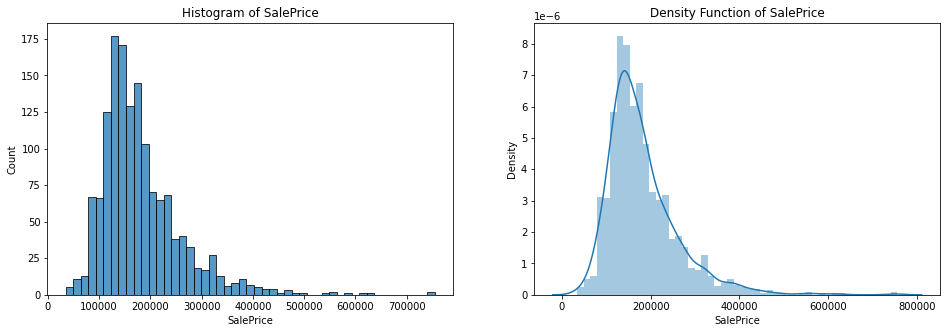

In [15]:
fig, axs = plt.subplots(1, 2, figsize=[16,5])
sns.histplot(data=ames, x='SalePrice', ax=axs[0])
axs[0].set_title('Histogram of SalePrice')
sns.distplot(ames['SalePrice'], ax=axs[1])
axs[1].set_title('Density Function of SalePrice');

In [16]:
ames['logSalePrice'] = ames.SalePrice.apply(np.log10)

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


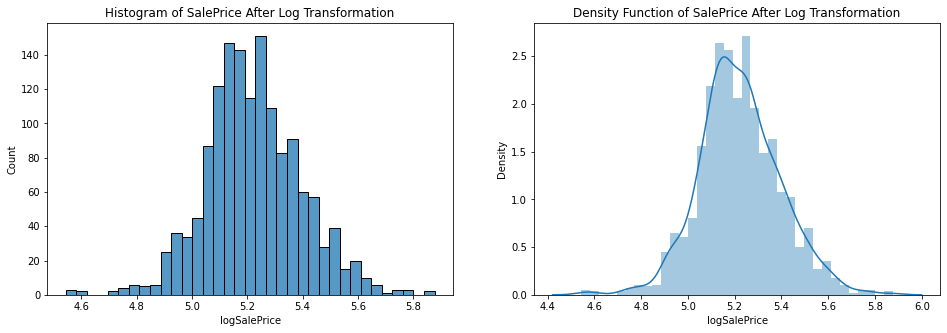

In [17]:
fig, axs = plt.subplots(1, 2, figsize=[16,5])
sns.histplot(data=ames, x='logSalePrice', ax=axs[0])
axs[0].set_title('Histogram of SalePrice After Log Transformation')
sns.distplot(ames['logSalePrice'], ax=axs[1])
axs[1].set_title('Density Function of SalePrice After Log Transformation');

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> Your answer here!

## Bivariate Exploration

> In this section, investigate relationships between pairs of variables in your
data. Make sure the variables that you cover here have been introduced in some
fashion in the previous section (univariate exploration).

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Your answer here!

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> Your answer here!

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

## Conclusions
>You can write a summary of the main findings and reflect on the steps taken during the data exploration.



> Remove all Tips mentioned above, before you convert this notebook to PDF/HTML


> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML or PDF` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!

